### Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy import argmax
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from PIL import Image, ImageOps
from sklearn.metrics import classification_report, confusion_matrix
import itertools

print(tf.__version__)


2.8.0


#### Load dataset, improve training datas with inverted color, normalize the values

In [2]:
mnist = tf.keras.datasets.mnist
(x_train_raw, y_train), (x_test_raw, y_test) = mnist.load_data()

# inverted color
inverted_color_x_train = 255 - x_train_raw
inverted_color_x_test = 255 - x_test_raw

x_train = tf.keras.utils.normalize(x_train_raw, axis=1)
x_test = tf.keras.utils.normalize(x_test_raw, axis=1)

inverted_color_x_train = tf.keras.utils.normalize(inverted_color_x_train, axis=1)
inverted_color_x_test = tf.keras.utils.normalize(inverted_color_x_test, axis=1)

# join the normal and inverted
x_train = np.append(x_train, inverted_color_x_train, 0)
x_test = np.append(x_test, inverted_color_x_test, 0)
y_train = np.append(y_train, y_train, 0)
y_test = np.append(y_test, y_test, 0)

#### Define model, compile and training

In [15]:
def create_model():
    model = tf.keras.models.Sequential()
    # cnn
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))

    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))

    # dense / classification
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dropout(0.2))
    # 10 possible output (0, 1, 2...9)
    model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

model = create_model()
history = model.fit(x_train, y_train, epochs=8, validation_data=(x_test, y_test))

Epoch 1/8
3750/3750 [==============================] - 50s 13ms/step - loss: 0.1640 - accuracy: 0.9499 - val_loss: 0.0508 - val_accuracy: 0.9846
Epoch 2/8
3750/3750 [==============================] - 52s 14ms/step - loss: 0.0554 - accuracy: 0.9827 - val_loss: 0.0334 - val_accuracy: 0.9898
Epoch 3/8
3750/3750 [==============================] - 51s 14ms/step - loss: 0.0397 - accuracy: 0.9875 - val_loss: 0.0347 - val_accuracy: 0.9886
Epoch 4/8
3750/3750 [==============================] - 53s 14ms/step - loss: 0.0306 - accuracy: 0.9903 - val_loss: 0.0323 - val_accuracy: 0.9902
Epoch 5/8
3750/3750 [==============================] - 53s 14ms/step - loss: 0.0240 - accuracy: 0.9920 - val_loss: 0.0303 - val_accuracy: 0.9904
Epoch 6/8
3750/3750 [==============================] - 54s 14ms/step - loss: 0.0202 - accuracy: 0.9933 - val_loss: 0.0314 - val_accuracy: 0.9908
Epoch 7/8
3750/3750 [==============================] - 54s 14ms/step - loss: 0.0175 - accuracy: 0.9943 - val_loss: 0.0378 - val_ac

#### Show the model's learning curve

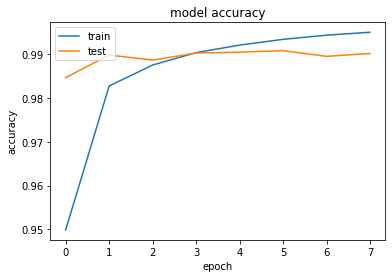

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Show the model's loss

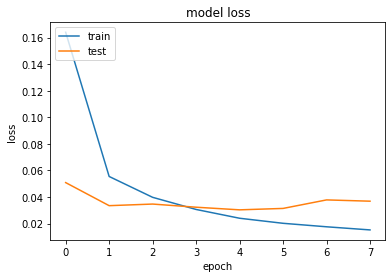

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

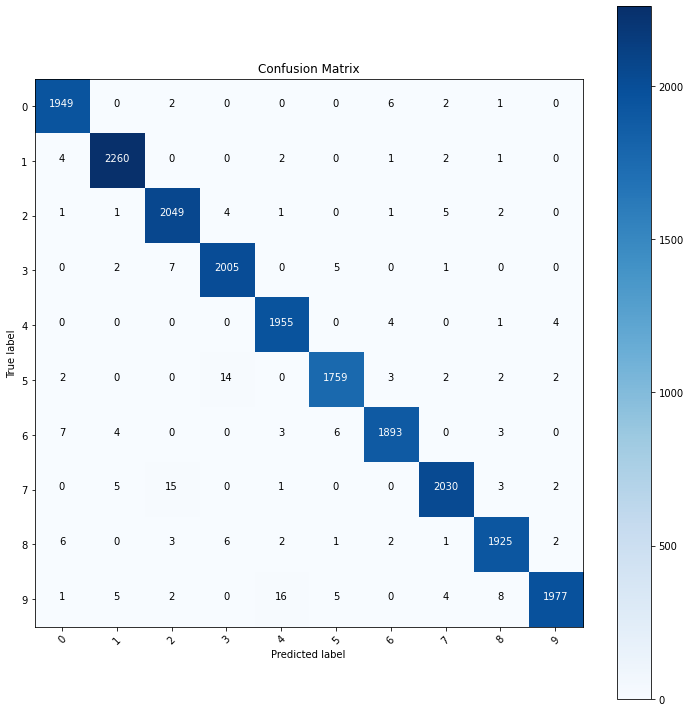

In [20]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


x_val = x_test
y_val = y_test
# Classificando toda base de teste
y_pred = model.predict(x_test)

y_test_c = np.argmax(y_pred, axis=1)
target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

#Confution Matrix
cm = confusion_matrix(y_val, y_test_c)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

In [22]:
# save model
model.save('digit_model.model')

INFO:tensorflow:Assets written to: digit_model.model\assets


In [4]:
# load the model saved
new_model = tf.keras.models.load_model('digit_model.model')
model = new_model

In [9]:
predictions = new_model.predict([x_test])

7


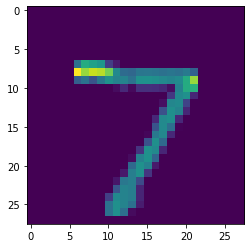

In [10]:
print(np.argmax(predictions[0]))
plt.imshow(x_test[0])
plt.show()

In [21]:
# load and prepare the image
def load_image(filename):
    # load the image
    img = ImageOps.grayscale(Image.open(filename))

    # reshape into a single sample with 1 channel
    #img = np.resize(img, (28,28,1))
    img = img.resize((28, 28))

    # convert to array
    img = img_to_array(img)
    img = img.reshape(1, 28, 28)

    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img

Número 0 - Chance 0.00000%
Número 1 - Chance 0.00000%
Número 2 - Chance 100.00000%
Número 3 - Chance 0.00000%
Número 4 - Chance 0.00000%
Número 5 - Chance 0.00000%
Número 6 - Chance 0.00000%
Número 7 - Chance 0.00000%
Número 8 - Chance 0.00000%
Número 9 - Chance 0.00000%
O número da imagem é: 2


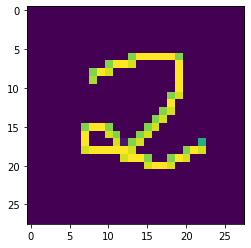

In [22]:
img = load_image('tests/2/img2.png')

predict = model.predict(img)
for ind, res in enumerate(predict[0]):
    print(f'Número {ind} - Chance {res * 100:.5f}%')
print('O número da imagem é:',argmax(predict))

plt.imshow(img[0])
plt.show()

Número 0 - Chance 0.00000%
Número 1 - Chance 0.00000%
Número 2 - Chance 100.00000%
Número 3 - Chance 0.00000%
Número 4 - Chance 0.00000%
Número 5 - Chance 0.00000%
Número 6 - Chance 0.00000%
Número 7 - Chance 0.00000%
Número 8 - Chance 0.00000%
Número 9 - Chance 0.00000%
O número da imagem é: 2


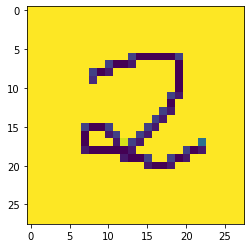

In [23]:
img = load_image('tests/2/img2_inv.png')

predict = model.predict(img)
for ind, res in enumerate(predict[0]):
    print(f'Número {ind} - Chance {res * 100:.5f}%')
print('O número da imagem é:',argmax(predict))

plt.imshow(img[0])
plt.show()

Número 0 - Chance 0.00000%
Número 1 - Chance 0.00000%
Número 2 - Chance 87.53479%
Número 3 - Chance 12.45736%
Número 4 - Chance 0.00000%
Número 5 - Chance 0.00000%
Número 6 - Chance 0.00000%
Número 7 - Chance 0.00785%
Número 8 - Chance 0.00000%
Número 9 - Chance 0.00000%
O número da imagem é: 2


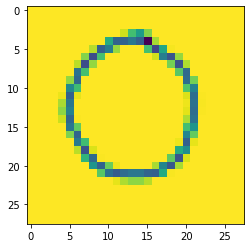

In [24]:
img = load_image('tests/0/0_0.png')

predict = model.predict(img)
for ind, res in enumerate(predict[0]):
    print(f'Número {ind} - Chance {res * 100:.5f}%')
print('O número da imagem é:',argmax(predict))

plt.imshow(img[0])
plt.show()